hepsini maks uzunluk yapacağına bölüm bölüm ayırarak uzunluk halletme kodu vardı onu yap süre azalsın.

In [16]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import sklearn
from tqdm import tqdm
df = pd.read_csv('movie10k.csv')

In [17]:
df.isnull().sum()
#0 null so no need to clear null
print(df.duplicated().sum())
#418 duplicated, no we need to clear duplicates
df=df.drop_duplicates() 
print(df.duplicated().sum())
#duplicates are cleared
df.head()

13
0


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [18]:
import re
def stringClear(text):
    cleanText = re.sub(r'[!,.""?''()]',' ',text)
    return cleanText

df['text'] = df['text'].apply(stringClear)
df['text'] = df['text'].apply(lambda x: x.lower())
df.head()

,text,label
0,i grew up b 1965 watching and loving the th...,0
1,when i put this movie in my dvd player and sa...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWordList = stopwords.words("english")

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in stopWordList]).apply(lambda x:" ".join(x))
#unnecessary words are eliminated
df.head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eceok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label
0,grew b 1965 watching loving thunderbirds mates...,0
1,put movie dvd player sat coke chips expectatio...,0
2,people know particular time past like feel nee...,0
3,even though great interest biblical movies bor...,0
4,im die hard dads army fan nothing ever change ...,1
5,terrible movie everyone said made laugh cameo ...,0
6,finally watched shocking movie last night dist...,1
7,caught film azn cable sounded like would good ...,0
8,may remake 1987 autumn's tale eleven years dir...,1
9,super ex girlfriend turned pleasant surprise r...,1


In [20]:

def catAsNum(val):
    if val=="positive":
        return 1
    else:
        return 0
#df['label']  =  df['label'].apply(catAsNum)

In [21]:
x = df["text"].values
y = df["label"].values

In [22]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2) 
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(7989,)
(1998,)
(7989,)
(1998,)


In [23]:
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")

train_encodings = tokenizer(list(x_train), padding = "longest", truncation=True)
test_encodings = tokenizer(list(x_test), padding = "longest", truncation=True)
#padding = "max_length", truncation=True
BATCHSIZE = 2

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(BATCHSIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCHSIZE)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [24]:
for x, y in test_dataset:
   print(x, y)

{'input_ids': <tf.Tensor: shape=(2, 1229), dtype=int32, numpy=
array([[   5,    5,    5, ..., 3746,    4,    3],
       [   5,    5,    5, ..., 3935,    4,    3]])>, 'token_type_ids': <tf.Tensor: shape=(2, 1229), dtype=int32, numpy=
array([[3, 3, 3, ..., 0, 0, 2],
       [3, 3, 3, ..., 0, 0, 2]])>, 'attention_mask': <tf.Tensor: shape=(2, 1229), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])>} tf.Tensor([1 1], shape=(2,), dtype=int64)
{'input_ids': <tf.Tensor: shape=(2, 1229), dtype=int32, numpy=
array([[   5,    5,    5, ..., 3054,    4,    3],
       [   5,    5,    5, ..., 2712,    4,    3]])>, 'token_type_ids': <tf.Tensor: shape=(2, 1229), dtype=int32, numpy=
array([[3, 3, 3, ..., 0, 0, 2],
       [3, 3, 3, ..., 0, 0, 2]])>, 'attention_mask': <tf.Tensor: shape=(2, 1229), dtype=int32, numpy=
array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])>} tf.Tensor([1 1], shape=(2,), dtype=int64)
{'input_ids': <tf.Tensor: shape=(2, 1229), dtype

In [25]:
""" 
import tensorflow_datasets as tfds
train_dataframe = tfds.as_dataframe(train_dataset) 
test_dataframe = tfds.as_dataframe(test_dataset) 
"""

' \nimport tensorflow_datasets as tfds\ntrain_dataframe = tfds.as_dataframe(train_dataset) \ntest_dataframe = tfds.as_dataframe(test_dataset) \n'

In [26]:
id2label = {
    0 : 'Negative',
    1 : 'Positive'
}

label2id = {v : k for k, v in id2label.items()}
num_classes = len(label2id)
print(label2id)

{'Negative': 0, 'Positive': 1}


In [27]:
#cased
from transformers import TFXLNetForSequenceClassification
model = TFXLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased",
    num_labels = 2,
    label2id = label2id,
    id2label = id2label
)


c:\Users\eceok\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a Ber

In [28]:
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), #hyperparameter
    metrics = ["accuracy"], #hyperparameter sayılır
    #options = run_opts
    run_eagerly=False
)
print(train_dataset)

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 2277), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 2277), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 2277), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [29]:
model.summary()

Model: "tfxl_net_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFXLNetMainLay  multiple                 116718336 
 er)                                                             
                                                                 
 sequence_summary (TFSequenc  multiple                 590592    
 eSummary)                                                       
                                                                 
 logits_proj (Dense)         multiple                  1538      
                                                                 
Total params: 117,310,466
Trainable params: 117,310,466
Non-trainable params: 0
_________________________________________________________________


In [30]:
from numba import jit, cuda
tf.config.experimental.set_memory_growth
@jit(target_backend='cuda')  
def func():
    EPOCHS = 1 #hyperparameter
    history = model.fit(
        x= train_dataset,
        validation_data = test_dataset,
        epochs = EPOCHS
    )
    return history
history = func()

C:\Users\eceok\AppData\Local\Temp\ipykernel_9484\1976903883.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='cuda')
C:\Users\eceok\AppData\Local\Temp\ipykernel_9484\1976903883.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "func" failed type inference due to: Untyped global name 'model': Cannot determine Numba type of <class 'transformers.models.xlnet.modeling_tf_xlnet.TFXLNetForSequenceClassification'>

File "..\..\..\..\AppData\Local\Temp\ipykernel_9484\1976903883.py", line 6:
<source missing, REPL/exec in use?>

  @jit(target_backend='cuda')
c:\Users\eceok\anaconda3\lib\site-packages\numba

   5/3995 [..............................] - ETA: 85:59:25 - loss: 0.7520 - accuracy: 0.3000

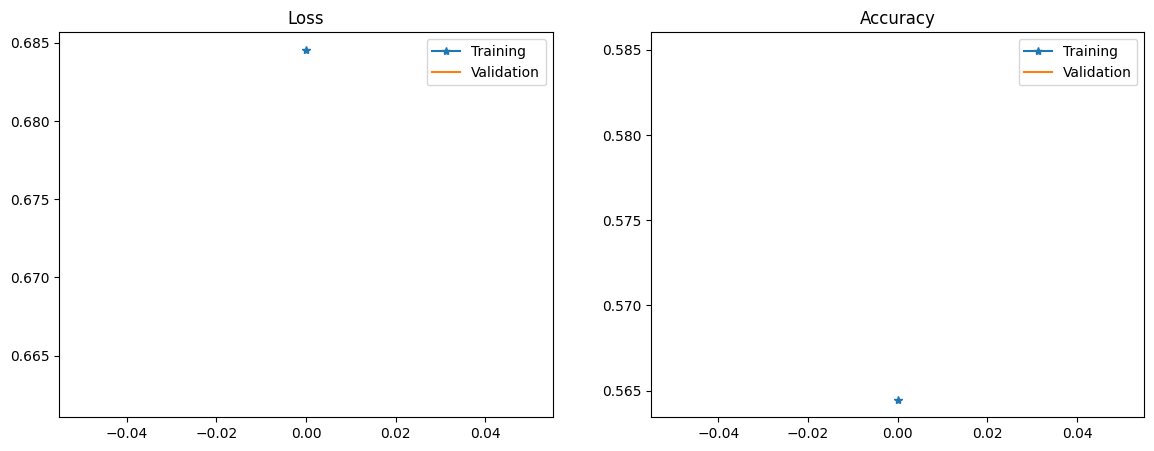

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = '*', label = 'Training')
plt.plot(history.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = '*', label = 'Training')
plt.plot(history.history['val_accuracy'], label = 'Validation')
plt.legend()

In [ ]:
out = model.predict(test_dataset)
pred = np.argmax(out[0], axis = 1)
pred

4/4 [==============================] - 112s 25s/step


array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

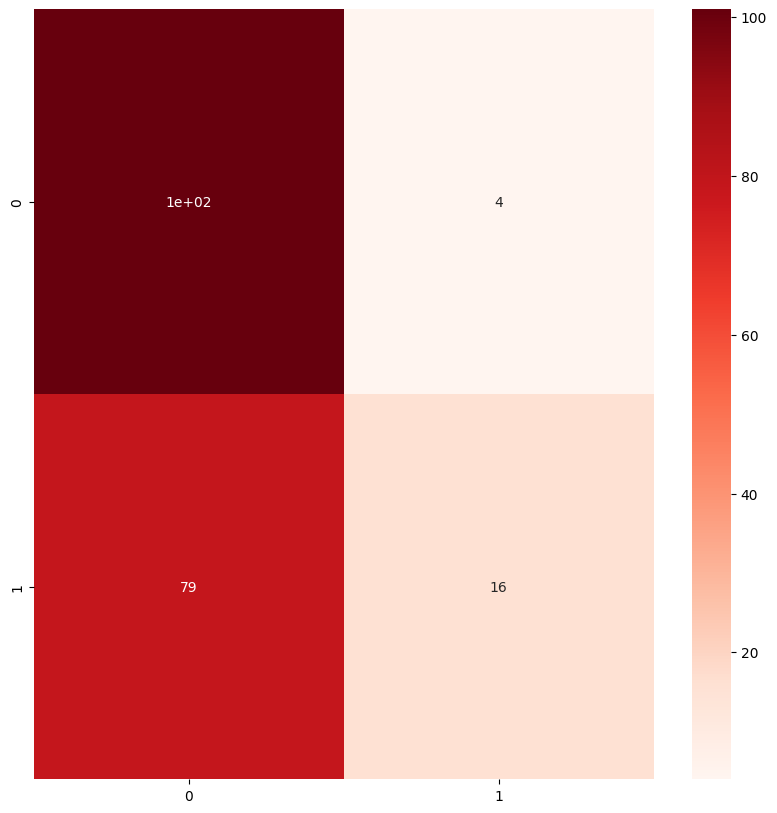

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.subplots(figsize = (10, 10))
sns.heatmap(cm, annot = True, cmap='Reds')
plt.show()